In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('darkgrid')

# Isochron Construction

The `Isochron` class takes 3 activity ratios with the respective uncertainty as an input:
1. `x`, `xe` = $\frac{^{232}Th}{^{238}U}_{activity}$
2. `y`, `ye` = $\frac{^{234}U}{^{238}U}_{activity}$
3. `z`, `ze` = $\frac{^{230}Th}{^{238}U}_{activity}$

The functionality of each method of this class is defined in each methods `docstring`

In [2]:
class Isochron:
    
    def __init__(self, x, xe, y, ye, z, ze, sample='ID'):
        
        '''__init__ method defines variables including decay constants and sample id
        and generates a linear regression based on the Osmond isochron'''
        
        #X = 232/238
        self.x = x
        self.xe = xe
        #Y = 234/238
        self.y = y
        self.ye = ye
        #Z = 230/238
        self.z = z
        self.ze = ze
        
        self.sample=sample
        
        from scipy.stats import linregress
        self.reg = linregress(self.x, self.z)
        
        self.l230 = 0.0000091577*1.0014
        self.l232 = 0.000000000049475
        self.l234 = 0.0000028263*0.9985
        self.l238 = 0.000000000155125
        
    def regression(self):
        
        '''prints out the regression parameters generated in __init__ method'''
        
        formula = 'z = '+ str(round(self.reg.slope, 4)) + ' * x + ' + str(round(self.reg.intercept, 6))
        r = 'Rsquared = ' + str(round(self.reg.rvalue,4))
        print(formula)
        print(r)
        return
    
    def Th_initial(self):
        
        '''calculates the initial 230Th/232Th atomic ratio from the regression slope and
        prints it'''
        
        self.Th_initial = self.reg.slope * self.l232/self.l230
        self.Th_initial_e = self.reg.stderr * self.l232/self.l230
        s = 'Th230/232 initial: ' + str(round(self.Th_initial,8)) + ' +-' + str(round(self.Th_initial_e,8))
        print(s)
        return
    
    def get_age_input(self):
        
        '''generate the input delta234_measured and Th230/U238 activity ratios 
        to calculate the isochron age unsing the U_Th_inverse class,
        which is defined below.'''
        
        d234u = (self.y-1)*1000
        d234ue = (self.ye)*1000
        
        th230u238 = self.reg.intercept
        th230u238e = self.reg.intercept_stderr
        
        dic = {'d234u': d234u.mean(),
               'd234u_e': d234ue.mean(),
               'Th230_U238': th230u238,
               'Th230_U238_e': th230u238e}
        
        return dic

    def isochron_age(self):
        
        '''parses the dictionary generated with the get_age_input method
        into the U_Th_inverse class. Calculated ages are printed.'''
        
        self.Age = U_Th_inverse(**self.get_age_input())
        self.age = round(self.Age.iter_age().age[0],0)
        self.age_e = round(self.Age.iter_age_e(),0)
        self.d234U_i = self.Age.d234U_i(self.age, self.age_e)
        
        print('isochron age = ' + str(self.age) + ' +-' +  str(self.age_e))
        print('d234U_i = ' + str(round(self.d234U_i[0],2)) + ' +-' +  str(round(self.d234U_i[1],2)))
        return
        
    def isochron_age_noprint(self):
        
        '''parses the dictionary generated with the get_age_input method
        into the U_Th_inverse class. Ages are not printed here, but the 
        variables are created for further use'''
        
        self.Age = U_Th_inverse(**self.get_age_input())
        self.age = round(self.Age.iter_age().age[0],0)
        self.age_e = round(self.Age.iter_age_e(),0)
        self.d234U_i = self.Age.d234U_i(self.age, self.age_e)
        
        return
    
    def plot_isochron(self):
        
        '''plots the input data and the respective Osmond isochron 
        unsing the least squares linear regression and the 95% confidence 
        interval'''

        self.f, self.a = plt.subplots()
        self.a.errorbar(self.x,
                        self.z,
                        xerr=self.xe,
                        yerr=self.ze,
                        capsize=2,
                        fmt='o ',
                        color='xkcd:purple',
                        mec='k')

        sns.regplot(self.x,
                    self.z,
                    color='xkcd:purple',
                    ax=self.a)
        
        self.a.set_ylabel(r'$^{230}Th/^{238}U$')
        self.a.set_xlabel(r'$^{232}Th/^{238}U$')
        self.a.set_title(self.sample)
        
        return self.a

# Age Calculation Class

The `U_Th_inverse` class calculates the $^{230}Th/U$ age based on measured values of $\delta^{234}U$ = `d234U` +- `d234U_e` and $\frac{^{230}Th}{^{238}U}_{activity}$ = `Th230_U238` +- `Th230_U238_e`. A Python implementation of the Microsoft Excel `GoalSeek` algorithm is used to iteratively determine the age that minimizes the `residue_N` functions.

In [3]:
class U_Th_inverse:
    
    def __init__(self,
                 d234u,
                 d234u_e,
                 Th230_U238,
                 Th230_U238_e):
        
        self.l_230 = 0.0000091577*1.0014
        self.l_232 = 0.000000000049475
        self.l_234 = 0.0000028263*0.9985
        self.l_238 = 0.000000000155125
        
        self.d234U = d234u
        self.d234U_e = d234u_e

        self.A_Th230_U238 = Th230_U238
        self.A_Th230_U238_e = Th230_U238_e
        
        self.startage = 1000
        
    
    def GS(self, fun, goal, x0, fTol=0.00000000001, MaxIter=1000):
        
        '''
        Goal Seek function of Excel
          via use of Line Search and Bisection Methods

        Inputs
          fun     : Function to be evaluated
          goal    : Expected result/output
          x0      : Initial estimate/Starting point
        '''
        
        # Initial check
        if fun(x0)==goal:
            print('Exact solution found')
            return x0

        # Line Search Method
        step_sizes=np.logspace(-1,4,6)
        scopes=np.logspace(1,5,5)

        vFun=np.vectorize(fun)

        for scope in scopes:
            break_nested=False
            for step_size in step_sizes:

                cApos=np.linspace(x0,x0+step_size*scope,int(scope))
                cAneg=np.linspace(x0,x0-step_size*scope,int(scope))

                cA=np.concatenate((cAneg[::-1],cApos[1:]),axis=0)

                fA=vFun(cA)-goal

                if np.any(np.diff(np.sign(fA))):

                    index_lb=np.nonzero(np.diff(np.sign(fA)))

                    if len(index_lb[0])==1:

                        index_ub=index_lb+np.array([1])

                        x_lb=np.asscalar(np.array(cA)[index_lb][0])
                        x_ub=np.asscalar(np.array(cA)[index_ub][0])
                        break_nested=True
                        break
                    else: # Two or more roots possible

                        index_ub=index_lb+np.array([1])

                        print('Other solution possible at around, x0 = ', np.array(cA)[index_lb[0][1]])

                        x_lb=np.asscalar(np.array(cA)[index_lb[0][0]])
                        x_ub=np.asscalar(np.array(cA)[index_ub[0][0]])
                        break_nested=True
                        break

            if break_nested:
                break
        if not x_lb or not x_ub:
            print('No Solution Found')
            return

        # Bisection Method
        iter_num=0
        error=10

        while iter_num<MaxIter and fTol<error:

            x_m=(x_lb+x_ub)/2
            f_m=fun(x_m)-goal

            error=abs(f_m)

            if (fun(x_lb)-goal)*(f_m)<0:
                x_ub=x_m
            elif (fun(x_ub)-goal)*(f_m)<0:
                x_lb=x_m
            elif f_m==0:
                print('Exact solution found')
                return x_m
                
            self.startage = x_m
            iter_num+=1

        return x_m    
    
    def d234U_i(self, age, age_e):
        '''
        back-calculate the d234U - initial based on a given age.
        The age to use as an corr_input here is typically the output of iter_age().age[0]
        '''
        delta =  self.d234U * np.e ** (self.l_234 * age)
        
        f1 = (self.d234U_e * np.e ** (self.l_234 * age))**2
        f2 = (self.d234U * np.e ** (self.l_234*(age+age_e)) - delta)**2
        delta_e = np.sqrt(f1 + f2)
        
        return delta, delta_e
    
    
    ######################################################################################################################
    
    '''
    CALCULATE RESIDUES FROM AGES
    age calculation formula for goal seek algorithm to 0
    taken from Hai Cheng's Excel Spreadsheet
    '''
        
        
    def residue_1(self, age):
        # uncorrected age
        f1 = 1 - np.e**(-self.l_230 * age)
        f2 = (self.d234U / 1000) * self.l_230 / (self.l_230-self.l_234)
        f3 = 1 - np.e**((self.l_234-self.l_230) * age)
        
        res = self.A_Th230_U238 - ( f1 + f2 * f3 )
        return res
    
    
    def residue_2(self, age):
        # AGE with [Th/U] max - AGE max
        f1 = 1 - np.e**(-self.l_230 * age)
        f2 = (self.d234U / 1000) * self.l_230 / (self.l_230-self.l_234)
        f3 = 1 - np.e**((self.l_234-self.l_230) * age)
        
        res = (self.A_Th230_U238+self.A_Th230_U238_e) - ( f1 + f2 * f3 )
        return res
    
    
    def residue_3(self, age):
        # AGE with [Th/U] max - AGE min
        f1 = 1 - np.e**(-self.l_230 * age)
        f2 = (self.d234U / 1000) * self.l_230 / (self.l_230-self.l_234)
        f3 = 1 - np.e**((self.l_234-self.l_230) * age)
        
        res = self.A_Th230_U238-self.A_Th230_U238_e - ( f1 + f2 * f3 )
        return res
    
    
    def residue_4(self, age):
        # AGE with d234U max - AGE min
        f1 = 1 - np.e**(-self.l_230 * age)
        f2 = ((self.d234U+self.d234U_e) / 1000) * self.l_230 / (self.l_230-self.l_234)
        f3 = 1 - np.e**((self.l_234-self.l_230) * age)
        
        res = self.A_Th230_U238 - ( f1 + f2 * f3 )
        return res
    
    
    def residue_5(self, age):
        # AGE with d234U min - AGE max
        f1 = 1 - np.e**(-self.l_230 * age)
        f2 = ((self.d234U-self.d234U_e) / 1000) * self.l_230 / (self.l_230-self.l_234)
        f3 = 1 - np.e**((self.l_234-self.l_230) * age)
        
        res = self.A_Th230_U238 - ( f1 + f2 * f3 )
        return res    
    
    
    def iter_age(self, x0 = 1000, goal = 0):
        
        '''
        iterate over multiple ages to approximate residue functions to 0;
        the x0 parameter is the starting value of the age - this value is arbitrary
        
        returns: pandas DataFrame with uncorrected ages as in template:
        Uncorrected age (Years) = age1
        AGE with [Th/U] max - AGE max = age2
        AGE with [Th/U] min - AGE min = age3
        AGE with d234U max - AGE min = age4
        AGE with d234U min - AGE max = age5

        '''
        
        self.age1 = self.GS(self.residue_1, goal, x0)
        self.age2 = self.GS(self.residue_2, goal, x0)
        self.age3 = self.GS(self.residue_3, goal, x0)
        self.age4 = self.GS(self.residue_4, goal, x0)
        self.age5 = self.GS(self.residue_5, goal, x0)
        
        dic = {'age' : [self.age1,
                        self.age2,
                        self.age3,
                        self.age4,
                        self.age5],
               'residue' : [self.residue_1(self.age1),
                            self.residue_2(self.age2),
                            self.residue_3(self.age3),
                            self.residue_4(self.age4),
                            self.residue_5(self.age5)]}
        dic = pd.DataFrame(dic)
        return dic
    
    
    def iter_age_e(self):
        '''
        calculate the absolute age error based on the ages determined through the iter_age method
        '''
        ages_uncorr = self.iter_age()
        error = np.sqrt( (ages_uncorr.age[1] - ages_uncorr.age[0])**2 + (ages_uncorr.age[4]-ages_uncorr.age[0])**2 )
        return error

# Miscellaneous Functions

In [4]:
def delta_to_R(delta):
    '''
    tranform detla notation to activity ratio
    '''
    
    A_234_238 = (delta/1000+1)
    return A_234_238


def rho(X, Y, ia=1, ib=1):
    '''
    calculate the error correlation between 2 variables after
    Ludwig, K.R., 2003. Mathematical–statistical treatment 
    of data and errors for 230 Th/U geochronology.
    Reviews in Mineralogy and Geochemistry, 52(1), pp.631-656.
    '''
    
    rhoXY = np.sqrt(X*Y / ((X+(1/ia))*(Y+(1/ib))))
    return  rhoXY


def fmt_input(ID, u238, u238e, th232, th232e, th230_u238, th230_u238e, delta234, delta234e):
    '''
    generate output for isoplotR:
    http://isoplotr.es.ucl.ac.uk
    
    this format is also used for the `Isochron` class
    of this package.
    
    requires uncertainties package:
    https://pythonhosted.org/uncertainties/
    
    returns:
    pandas Dataframe
    '''
    
    l230 = 0.0000091577*1.0014
    l232 = 0.000000000049475
    l234 = 0.0000028263*0.9985
    l238 = 0.000000000155125
    
    from uncertainties import ufloat
    
    #X = 232/238
    U238 = np.array([ufloat(u238[i], u238e[i]) for i in u238.index])
    Th232 = np.array([ufloat(th232[i], th232e[i]) for i in th232.index])
    
    Th232U238 = ((Th232/232.032*l232)/1000) / (U238/238.050785*l238)
    X = np.array([i.n for i in Th232U238])
    Xe = np.array([i.s for i in Th232U238])

    #Y = 234/238
    delta = np.array([ufloat(delta234[i],delta234e[i]) for i in delta234.index])
    U234U238 = delta_to_R(delta)
    Y = np.array([i.n for i in U234U238])
    Ye = np.array([i.s for i in U234U238])

    #Z = 230/238
    Z = th230_u238
    Ze = th230_u238e

    #rho
    rhoXY = rho(X,Y)
    rhoXZ = rho(X,Z)
    rhoYZ = rho(Y,Z)

    #output file
    dic = {'ID' : ID,
           'X' : X,
           'errx' : Xe,
           'Y' : Y,
           'erry' : Ye,
           'Z' : Z,
           'errz' : Ze,
           'rhoXY': rhoXY,
           'rhoXZ': rhoXZ,
           'rhoYZ': rhoYZ}
    out = pd.DataFrame(dic)
    
    return out


def ensemble(df, n=5, remove=1):
    '''
    This function takes a Dataframe (df) as formatted above and calculates
    a set (size n=5) of isochron ages by randomly removing a number of data 
    points (remove=1).
    '''
    
    isochrons = np.array([])
    isochrons_e = np.array([])
    for i in range(n):
        df_sub = df.sample(df.index.size-remove) 
    
        ipt = fmt_input(df_sub.labid,
                        df_sub.u238,
                        df_sub.u238e,
                        df_sub.th232,
                        df_sub.th232e,
                        df_sub.th230u238,
                        df_sub.th230u238e,
                        df_sub.u234,
                        df_sub.u234e)

        Age = Isochron(ipt.X,
                       ipt.errx,
                       ipt.Y,
                       ipt.erry,
                       ipt.Z,
                       ipt.errz,
                       sample='')
        Age.isochron_age_noprint()
        
        isochrons = np.append(isochrons, Age.age)
        isochrons_e = np.append(isochrons_e, Age.age_e)
        
    return isochrons.mean(), isochrons_e.mean()

# Example

Data is loaded from an excel table

In [5]:
df = pd.read_excel('Sample Data.xlsx')

The `fmt_input` function is used to generate the activity ratios from the input dataframe, that are needed for the `Isochron`class.

In our example, the input data has the following format:
1. `u238` - $^{238}U \, [ppb]$ 
2. `th232` - $^{232}Th \, [ppt]$ 
3. `th230u238` - $\frac{^{230}Th}{^{238}U}_{activity}$ 
4. `u234` - $\delta^{234}U$

including the respective analytical uncertainties at a $2\sigma$ level

<IPython.core.display.Javascript object>


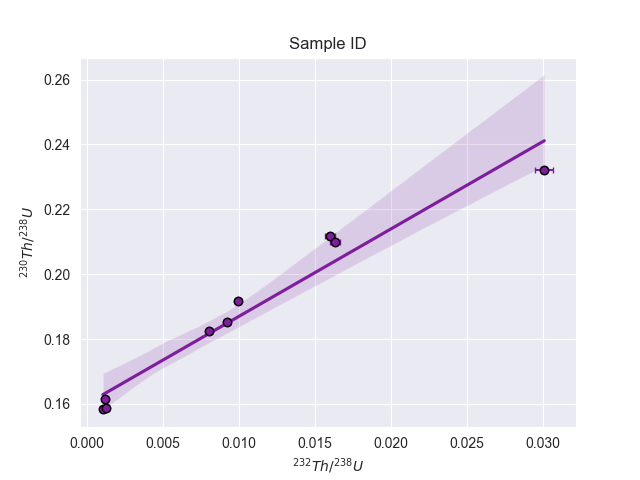

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


z = 2.6979 * x + 0.160025
Rsquared = 0.9758
isochron age = 12324.0 +-254.0
d234U_i = 506.3 +-2.2
Th230/232 initial: 1.456e-05 +-1.23e-06


In [7]:
# generate input dataframe
ipt = fmt_input(df.labid,
                df.u238,
                df.u238e,
                df.th232,
                df.th232e,
                df.th230u238,
                df.th230u238e,
                df.u234,
                df.u234e)

# parse dataframe to isochron class
Iso = Isochron(ipt.X,
               ipt.errx,
               ipt.Y,
               ipt.erry,
               ipt.Z,
               ipt.errz,
               sample='Sample ID')

# plot/print values of interest
Iso.plot_isochron()
Iso.regression()
Iso.isochron_age()
Iso.Th_initial()


# save files and graphs

ipt.to_excel('IsoplotR_input.xlsx')

plt.savefig('plot 1.png')
plt.savefig('plot 1.svg')